<a href="https://colab.research.google.com/github/peguescj/data-management/blob/main/PS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#aok: typo in file name: should be ".ipynb" not "ipynb"--forgot dot "."

In [1]:
#---------------------------SETUP----------------------------------
#get useful libraries
import time, os, sys, re #basics
import zipfile, json, datetime, string   #string for annotating points in scatter
import numpy as np #basic math
from statistics import * #stats

import matplotlib.pyplot as plt #import pylab as plt #apparently discouraged now:
 #https://stackoverflow.com/questions/11469336/what-is-the-difference-between-pylab-and-pyplot
 #https://www.tutorialspoint.com/matplotlib/matplotlib_pylab_module.htm

import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler
#s4 = Styler(df4, uuid_len=0, cell_ids=False)

import urllib  #weird, guess need to have os and pandas imported for this to work  %TODO/LATER ditch it, its weird anyway, just use wget/curl

from google.colab import files

#import webbrowser

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter() #this enables spreadsheet view upon calling dataframe (without() )

#many tricks how to extend notebook functionality
#https://coderzcolumn.com/tutorials/python/list-of-useful-magic-commands-in-jupyter-notebook-lab
#will display all output not just last command
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#MAGICS and THEMES/STYLES: important! does affect not just shading/colors, but also fonts, spacing, etc
#(even if you only select default (v not selecting anything) [but does seem to work better if you do make explicit sleections])

###magics: https://ipython.readthedocs.io/en/stable/interactive/magics.html
#most essential setup for vis: it does affect vis! careful!! stick with inline, maybe notebook; others mostly for non-notebook, eg spyder environ
#https://jakevdp.github.io/PythonDataScienceHandbook/04.00-introduction-to-matplotlib.html recomends *inline*!
#show current one:
#%matplotlib
#%matplotlib --list
#interactive plots:
#%matplotlib notebook
#static images of your plot:
%matplotlib inline
#may play with this one and other magics (btw default is probably agg)
#%matplotlib nbagg

###themes/styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
#https://jakevdp.github.io/PythonDataScienceHandbook/04.11-settings-and-stylesheets.html
#https://matplotlib.org/stable/tutorials/introductory/customizing.html
#here more about art and style than under the hood functionality as with magics, explore and experiment
#many may find 'default' or seaborn ones more pleasing; my fav 'classic' is back from 90s ;)
#plt.style.available #list available styles :) may install more
#plt.style.use('default') # more delicate subtle than classic
plt.style.use('classic')  #  'seaborn-whitegrid' 'seaborn-white' 'seaborn-poster'
# btw: magics v theme/style sequence matters, eg if i specify classic style before inline magic, i wouldnt get grey bounding box im getting

PS2 Submission
Data Sources and explainations within this linked doc
https://docs.google.com/document/d/1UtEePRrVqUHWjPAYSCcnqK9rabKoOY9U-yETtrxUfuk/edit?usp=sharing
aok: need to make it public first

In [2]:
#Uploading the NJ Per Pupil Expenditure Data as a CSV.
#urllib.request.urlretrieve("https://docs.google.com/uc?id=1HCCdqd0pEMFDnBSAjlQ-AULTGKQpbM1P&export=download", "PerPupil.csv")
!wget -q -O PerPupil.csv https://docs.google.com/uc?id=1HCCdqd0pEMFDnBSAjlQ-AULTGKQpbM1P&export=download

In [3]:
# basic navigation
#wd =  'PerPupil'  #'C:\Users\ref\Desktop\junk' # may need to ADJUST
#os.makedirs(wd)
#os.getcwd() #pwd
!pwd
#os.listdir() #compare to clicking on the left the folder icon #dir
!ls
#os.chdir(wd)
#os.getcwd()

/content
PerPupil.csv  sample_data


In [4]:
dat=pd.read_csv('PerPupil.csv') #read it in  ; or full path: '/content/final_data.csv'

In [5]:
dat.columns #list var names

Index(['county_id', 'coname', 'district_id', 'distname', 'line_desc', 'year1',
       'year2', 'year3', 'year4', 'year5'],
      dtype='object')

In [6]:
dat["year1"][0:50] #How much the school spent money in 2016

0     $11,318 
1      $7,550 
2      $7,202 
3        $264 
4         $84 
5      $1,277 
6      $1,103 
7      $1,262 
8      $1,062 
9      $1,164 
10       $635 
11         $0 
12        $55 
13         $0 
14        $20 
15      30.63%
16    $19,422 
17    $12,021 
18    $11,376 
19       $424 
20       $220 
21     $2,864 
22     $2,605 
23     $1,602 
24     $1,290 
25     $2,644 
26     $1,477 
27         $0 
28       $235 
29        $32 
30       $111 
31      33.45%
32    $11,998 
33     $6,343 
34     $5,909 
35       $382 
36        $52 
37     $1,397 
38     $1,299 
39     $1,197 
40       $863 
41     $2,533 
42     $1,292 
43         $0 
44       $292 
45       $161 
46        $22 
47      33.44%
48    $49,255 
49    $28,329 
Name: year1, dtype: object

In [ ]:
#Looking to see if the total cost is static over years
#Seems like previous years spending is a good indicator of next years - Is there a built in way to regress in python?
dat[["year1","year2", "year3"]][0:50]

year1     year2     year3
0   $11,318   $11,148   $11,731 
1    $7,550    $7,465    $7,937 
2    $7,202    $7,218    $7,693 
3      $264      $192      $158 
4       $84       $56       $86 
5    $1,277    $1,235    $1,201 
6    $1,103    $1,045    $1,004 
7    $1,262    $1,276    $1,345 
8    $1,062    $1,083    $1,093 
9    $1,164    $1,117    $1,184 
10     $635      $633      $656 
11       $0        $0        $0 
12      $55       $53       $54 
13       $0       $14        $0 
14      $20       $17       $17 
15    30.63%    31.14%    33.65%
16  $19,422   $16,594   $18,288 
17  $12,021   $10,830   $11,615 
18  $11,376   $10,520   $11,046 
19     $424      $131      $370 
20     $220      $179      $198 
21   $2,864    $1,974    $2,040 
22   $2,605    $1,780    $1,757 
23   $1,602    $1,584    $1,727 
24   $1,290    $1,314    $1,365 
25   $2,644    $2,085    $2,688 
26   $1,477    $1,245    $1,386 
27       $0        $0        $0 
28     $235      $102      $166 
29      $32       $36       $73 
30     $111       $65       $97 
31    33.45%    35.48%    35.17%
32  $11,998   $11,951   $13,552 
33   $6,343    $6,282    $7,243 
34   $5,909    $5,862    $6,650 
35     $382      $298      $384 
36      $52      $121      $209 
37   $1,397    $1,430    $1,591 
38   $1,299    $1,325    $1,466 
39   $1,197    $1,236    $1,471 
40     $863      $870    $1,041 
41   $2,533    $2,459    $2,659 
42   $1,292    $1,287    $1,372 
43       $0        $0        $0 
44     $292      $303      $346 
45     $161       $95       $46 
46      $22       $23       $25 
47    33.44%    35.04%    39.21%
48  $49,255   $48,544   $54,172 
49  $28,329   $27,388   $30,393

In [7]:
#Scatter plot to visualize the above a bit better
dat.plot(kind='scatter', y='year1', x='year2')

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='year2', ylabel='year1'>

Error in callback <function flush_figures at 0x7a27e9108ca0> (for post_execute):


KeyboardInterrupt: ignored

Realized after I ran it that a scatterplot is not useful for this dataset unless you've manipulated the data onto more interesting variables. Whoops!

In [ ]:
#Uploading the NJ Median Income and Populations by County - ideally to compare with Per Pupil spending when we merge
#UGLY - Includes NJ and USA as a whole ALPHABETICALLY in the chart, not at the bottom or top.
#Is there a way to cull specific entires? I assume there's a simple drop command by variable number. In this case we could
#clear it by dropping all variables with no "Rank" as USA and NJ totals were skipped.
pd.read_html('https://en.wikipedia.org/wiki/List_of_New_Jersey_locations_by_per_capita_income',match='Population',flavor=None)[0].head(22)

Rank         County Per capita income Median household income  \
0    1.0      Hunterdon           $48,489                $100,980   
1    2.0         Morris           $47,342                 $96,747   
2    3.0       Somerset           $47,067                 $97,440   
3    4.0         Bergen           $42,006                 $81,708   
4    5.0       Monmouth           $40,976                 $82,265   
5    6.0         Mercer           $36,016                 $71,217   
6    7.0         Sussex           $35,982                 $83,089   
7    NaN     New Jersey           $34,858                 $69,811   
8    8.0     Burlington           $34,802                 $76,258   
9    9.0          Union           $34,096                 $66,791   
10  10.0       Cape May           $33,571                 $54,292   
11  11.0      Middlesex           $33,289                 $77,615   
12  12.0         Warren           $32,985                 $71,364   
13  13.0          Essex           $31,535                 $55,125   
14  14.0     Gloucester           $31,210                 $72,664   
15  15.0         Hudson           $31,024                 $55,275   
16  16.0          Ocean           $29,826                 $59,620   
17  17.0         Camden           $29,478                 $60,976   
18   NaN  United States           $27,334                 $51,914   
19  18.0          Salem           $27,296                 $59,441   
20  19.0       Atlantic           $27,247                 $54,766   
21  20.0        Passaic           $26,095                 $54,944   

   Median family income  Population  Number of households  
0              $121,166      128349                 47169  
1              $114,694      492276                180534  
2              $115,214      323444                117759  
3              $100,310      905116                335730  
4              $102,074      630380                233983  
5               $88,694      366513                133155  
6               $93,701      149265                 54752  
7               $84,904     8791894               3214360  
8               $91,185      448734                166318  
9               $80,818      536499                188118  
10              $69,978       97265                 40812  
11              $91,543      809858                281186  
12              $85,635      108692                 41480  
13              $68,683      783969                283712  
14              $85,832      288288                104271  
15              $58,968      634266                246437  
16              $73,672      576567                221111  
17              $74,385      513657                190980  
18              $62,982   308745538             116716292  
19              $72,537       66083                 25290  
20              $66,920      274549                102847  
21              $67,208      501226                166785

In [8]:
#Uploading the Nj Graduation Rate by category as an xlsv - in future I have versions of these that are split in a more useful manner
#Base document is near unusable in how it coded the attributes - has all of the different categories listed next to one another
#so they're all interpreted under the same variable as one another
#urllib.request.urlretrieve("https://docs.google.com/uc?id=1g168RZqCUj3aujXJP2CEssnLHBmYbDQw&export=download ", "GradRate.xlsv")
!wget -q -O GradRate.xlsv https://docs.google.com/uc?id=1g168RZqCUj3aujXJP2CEssnLHBmYbDQw&export=download

In [ ]:
# basic navigation
#wd =  'PerPupil'  #'C:\Users\ref\Desktop\junk' # may need to ADJUST
#os.makedirs(wd)
#os.getcwd() #pwd
!pwd
#os.listdir() #compare to clicking on the left the folder icon #dir
!ls
#os.chdir(wd)
#os.getcwd()

/content
GradRate.xlsv  sample_data  Staff.xlsv


In [9]:
dat=pd.read_excel('GradRate.xlsv') #read it in  ; or full path: '/content/GradRate.xlsv'

In [10]:
dat.columns #list var names

Index(['County Code', 'County Name', 'District Code', 'District Name',
       'School Code', 'School Name', 'Student Group', 'Graduation Rate',
       'Cohort Count', 'Graduated'],
      dtype='object')

In [ ]:
dat["Graduation Rate"][0:50] #Pulling up all of the grad rates - base is not useful as it has "All" "Female" "Male" in same line
#Have version from last year that I've applied changes too - curious if python can help do those for me so just using base

0         N
1      93.4
2      69.6
3      75.9
4      66.2
5      81.7
6      70.8
7      64.3
8      72.0
9         N
10        *
11        N
12        *
13     71.6
14     76.6
15        *
16     89.8
17        N
18     93.4
19     69.6
20     75.9
21     66.2
22     81.7
23     70.8
24     64.3
25     72.0
26        N
27        *
28        N
29        *
30     71.6
31     76.6
32        *
33     89.8
34        *
35    100.0
36     96.9
37     96.5
38        N
39     98.1
40     96.2
41        *
42     96.1
43        N
44     92.9
45        N
46        N
47     94.7
48     97.2
49    100.0
Name: Graduation Rate, dtype: object

In [ ]:
#let's show off the problem I mentioned
#all different groups on the same line for grad rate - Have to splice them into seperate lines to compare!
#Did manually before - must be way to automate it.
dat[["Graduation Rate","Cohort Count", "Student Group"]][0:50]

Graduation Rate Cohort Count                                Student Group
0                N            N             American Indian or Alaska Native
1             93.4           91  Asian, Native Hawaiian, or Pacific Islander
2             69.6          138                    Black or African American
3             75.9          431          Economically Disadvantaged Students
4             66.2           65                             English Learners
5             81.7          224                                       Female
6             70.8          195                                     Hispanic
7             64.3           14                            Homeless Students
8             72.0          250                                         Male
9                N            N                             Migrant Students
10               *            *                  Military-Connected Students
11               N            N               Non-Binary/Undesignated Gender
12               *            *                      Students in Foster Care
13            71.6           74                   Students with Disabilities
14            76.6          474                                        Total
15               *            *                            Two or More Races
16            89.8            *                                        White
17               N            N             American Indian or Alaska Native
18            93.4           91  Asian, Native Hawaiian, or Pacific Islander
19            69.6          138                    Black or African American
20            75.9          431          Economically Disadvantaged Students
21            66.2           65                             English Learners
22            81.7          224                                       Female
23            70.8          195                                     Hispanic
24            64.3           14                            Homeless Students
25            72.0          250                                         Male
26               N            N                             Migrant Students
27               *            *                  Military-Connected Students
28               N            N               Non-Binary/Undesignated Gender
29               *            *                      Students in Foster Care
30            71.6           74                   Students with Disabilities
31            76.6          474                                        Total
32               *            *                            Two or More Races
33            89.8            *                                        White
34               *            *             American Indian or Alaska Native
35           100.0           23  Asian, Native Hawaiian, or Pacific Islander
36            96.9           65                    Black or African American
37            96.5          257          Economically Disadvantaged Students
38               N            N                             English Learners
39            98.1          214                                       Female
40            96.2          156                                     Hispanic
41               *            *                            Homeless Students
42            96.1          178                                         Male
43               N            N                             Migrant Students
44            92.9           14                  Military-Connected Students
45               N            N               Non-Binary/Undesignated Gender
46               N            N                      Students in Foster Care
47            94.7           57                   Students with Disabilities
48            97.2          392                                        Total
49           100.0            *                            Two or More Races

In [ ]:
#How to solve? We simplify and remove all but the interested variable.

In [11]:
datsmall=dat[['County Code', 'County Name', 'District Code', 'District Name',
       'School Code', 'School Name', 'Student Group', 'Graduation Rate',
       'Cohort Count', 'Graduated']][0:50]

In [12]:
datsmall.pivot(index='index', columns='Students with Disabilities', values='Graduation Rate') #aok: breaks

KeyError: ignored

In [ ]:
datsmall.unstack()

County Code  0      01
             1      01
             2      01
             3      01
             4      01
                  ... 
Graduated    45      N
             46      N
             47     54
             48    381
             49      *
Length: 500, dtype: object

In [ ]:
datsmall.index

RangeIndex(start=0, stop=50, step=1)

In [ ]:
TotalGrad=dat[dat['Student Group']=='Total']

In [ ]:
TotalGrad

County Code County Name  District Code  \
14             01    Atlantic          110.0   
31             01    Atlantic          110.0   
48             01    Atlantic          120.0   
65             01    Atlantic          120.0   
82             01    Atlantic          590.0   
...           ...         ...            ...   
12424          80     Charter         8010.0   
12441          80     Charter         8010.0   
12458          80     Charter         8060.0   
12475          80     Charter         8060.0   
12492          99       State         9999.0   

                                           District Name  School Code  \
14                         Atlantic City School District         10.0   
31                         Atlantic City School District        888.0   
48            Atlantic County Vocational School District         10.0   
65            Atlantic County Vocational School District        888.0   
82                        Buena Regional School District         25.0   
...                                                  ...          ...   
12424  Union County Teams Charter School-High School/...        888.0   
12441  Union County Teams Charter School-High School/...        980.0   
12458             University Academy Charter High School        888.0   
12475             University Academy Charter High School        990.0   
12492                                              State        999.0   

                                   School Name Student Group Graduation Rate  \
14                   Atlantic City High School         Total            76.6   
31                                    District         Total            76.6   
48     Atlantic County Institute Of Technology         Total            97.2   
65                                    District         Total            97.2   
82                  Buena Regional High School         Total            85.2   
...                                        ...           ...             ...   
12424                                 District         Total            97.2   
12441        Union County Teams Charter School         Total            97.2   
12458                                 District         Total            95.2   
12475   University Academy Charter High School         Total            95.2   
12492                                    State         Total            90.9   

      Cohort Count Graduated  
14             474       363  
31             474       363  
48             392       381  
65             392       381  
82             142       121  
...            ...       ...  
12424           36        35  
12441           36        35  
12458          104        99  
12475          104        99  
12492       106822     97079  

[735 rows x 10 columns]

In [13]:
GradDrop=dat[['District Code', 'District Name', 'School Name', 'Student Group', 'Graduation Rate',
       'Cohort Count', 'Graduated']]

In [14]:
#Now, for PS2, let's include also specifically pull out Black students graduation rate.
BlackGradSchool=GradDrop[dat['Student Group']=='Black or African American']

In [15]:
#Exactly what we wanted.
BlackGradSchool

District Code                                      District Name  \
2              110.0                      Atlantic City School District   
19             110.0                      Atlantic City School District   
36             120.0         Atlantic County Vocational School District   
53             120.0         Atlantic County Vocational School District   
70             590.0                     Buena Regional School District   
...              ...                                                ...   
12412         8010.0  Union County Teams Charter School-High School/...   
12429         8010.0  Union County Teams Charter School-High School/...   
12446         8060.0             University Academy Charter High School   
12463         8060.0             University Academy Charter High School   
12480         9999.0                                              State   

                                   School Name              Student Group  \
2                    Atlantic City High School  Black or African American   
19                                    District  Black or African American   
36     Atlantic County Institute Of Technology  Black or African American   
53                                    District  Black or African American   
70                  Buena Regional High School  Black or African American   
...                                        ...                        ...   
12412                                 District  Black or African American   
12429        Union County Teams Charter School  Black or African American   
12446                                 District  Black or African American   
12463   University Academy Charter High School  Black or African American   
12480                                    State  Black or African American   

      Graduation Rate Cohort Count Graduated  
2                69.6          138        96  
19               69.6          138        96  
36               96.9           65        63  
53               96.9           65        63  
70               81.0           21        17  
...               ...          ...       ...  
12412            96.0           25        24  
12429            96.0           25        24  
12446            94.6           56        53  
12463            94.6           56        53  
12480            85.8        15302     13130  

[735 rows x 7 columns]

In [16]:
#One step further, let's put this down to District level data only.
BlackGrad=BlackGradSchool[dat['School Name']=='District']

<ipython-input-16-93052694c1a0>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  BlackGrad=BlackGradSchool[dat['School Name']=='District']


In [17]:
#Now we have all of the black students graduation rates, at only the district level.
BlackGrad

District Code                                      District Name  \
19             110.0                      Atlantic City School District   
53             120.0         Atlantic County Vocational School District   
87             590.0                     Buena Regional School District   
121           1310.0                Egg Harbor Township School District   
189           1790.0   Greater Egg Harbor Regional High School District   
...              ...                                                ...   
12310         7325.0                        Team Academy Charter School   
12344         7410.0    Chartertech High School For The Performing Arts   
12378         7503.0  Paterson Charter School For Science And Techno...   
12412         8010.0  Union County Teams Charter School-High School/...   
12446         8060.0             University Academy Charter High School   

      School Name              Student Group Graduation Rate Cohort Count  \
19       District  Black or African American            69.6          138   
53       District  Black or African American            96.9           65   
87       District  Black or African American            81.0           21   
121      District  Black or African American            90.8           65   
189      District  Black or African American            89.0          172   
...           ...                        ...             ...          ...   
12310    District  Black or African American            95.1          184   
12344    District  Black or African American            96.6           29   
12378    District  Black or African American            97.1            *   
12412    District  Black or African American            96.0           25   
12446    District  Black or African American            94.6           56   

      Graduated  
19           96  
53           63  
87           17  
121          59  
189         153  
...         ...  
12310       175  
12344        28  
12378         *  
12412        24  
12446        53  

[313 rows x 7 columns]

In [ ]:
#Let's start on adding in the PS2 data. We'll still be using the Graduation Rate data as uploaded before, but instead of Per Pupil funding
#We'll be using a new data set that shows the race and gender breakdown of staff at schools
#These both have District Codes and School Codes, so we can merge off of those to then examine what connections we can find.

In [18]:
#Uploading a new dataset, which has race and gender breakdowns of certified staff at schools
#Has county, school, and district level data, as well as splitting Admin, Teachers, Special Service, and Supervisor staff
#into seperate lines, so we can examine each of those independantly
#urllib.request.urlretrieve("https://docs.google.com/uc?id=1Ll2krjd7subYxXDqj24pq9dLSfPYEXfw&export=download  ", "Staff.xlsv")
!wget -q -O Staff.xlsv https://docs.google.com/uc?id=1Ll2krjd7subYxXDqj24pq9dLSfPYEXfw&export=download

In [ ]:
# basic navigation
#wd =  'Staff'  #'C:\Users\ref\Desktop\junk' # may need to ADJUST
#os.makedirs(wd)
#os.getcwd() #pwd
!pwd
#os.listdir() #compare to clicking on the left the folder icon #dir
!ls
#os.chdir(wd)
#os.getcwd()

/content
GradRate.xlsv  sample_data  Staff.xlsv


In [19]:
dat=pd.read_excel('Staff.xlsv',
                  sheet_name='DISTRICT') #Reading in the data from the District level sheet

In [20]:
dat.columns #Examine our variables to ensure it imported correctly

Index(['This excel spread sheet contains one table with the the 2022-2023 NJ certificated staff data district counts. The table spans columns A through Y and rows 2 through 2678, with row 2 as the header row. This table includes certificated staff data reported by the districts aggregated at the district level.  The district data includes counts and percentages by  positions (Administrators, Special Services, Teachers and Supervisors/Coordinators), race and gender.',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10',
       'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14',
       'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24'],
      dtype='object')

In [21]:
#Hmm, problem right away - the state uses the first line in order to explain the database. Let's drop that!
dat=pd.read_excel('Staff.xlsv',
                  sheet_name='DISTRICT',
                  skiprows=1)



In [22]:
dat.columns #Examine our variables to ensure it imported correctly

Index(['Co Code', 'County', 'Dist Code', 'District', 'Position', 'White',
       '%White', 'Black', '%Black', 'Hispanic', '%Hispanic', 'Asian', '%Asian',
       'American Indian', '%American Indian', 'Hawaiian Native',
       '%Hawaiian Native', 'Two or More Races', '%Two or More Races', 'Total',
       'Male', '%Male', 'Female', '%Female', '%Non Binary'],
      dtype='object')

In [23]:
#Let's refine this down to just the percentage based rates and the district codes.
AllStaffClean=dat[['County','Dist Code','District','Position','%White','%Black','%Hispanic','%Asian','%Male','%Female']]

In [24]:
#Looks good! But, Admin, Special Service, Teacher, and Supervisor are in the same row.
AllStaffClean

County  Dist Code                         District  \
0     Atlantic       10.0  Absecon Public Schools District   
1     Atlantic       10.0  Absecon Public Schools District   
2     Atlantic       10.0  Absecon Public Schools District   
3     Atlantic       10.0  Absecon Public Schools District   
4     Atlantic      110.0    Atlantic City School District   
...        ...        ...                              ...   
2672  Charters     8140.0       The Village Charter School   
2673  Charters     8140.0       The Village Charter School   
2674  Charters     8140.0       The Village Charter School   
2675  Charters     8140.0       The Village Charter School   
2676       NaN        NaN                              NaN   

                      Position  %White  %Black  %Hispanic  %Asian  %Male  \
0               Administrators   100.0     0.0        0.0     0.0   40.0   
1              Special Service    95.1     0.0        4.9     0.0    0.0   
2                      Teacher    95.6     1.1        1.1     1.1   16.5   
3     Supervisors/Coordinators   100.0     0.0        0.0     0.0    0.0   
4               Administrators    23.1    66.2        4.6     0.0   32.3   
...                        ...     ...     ...        ...     ...    ...   
2672            Administrators    66.7    33.3        0.0     0.0    0.0   
2673           Special Service    33.3    66.7        0.0     0.0    0.0   
2674                   Teacher    66.7    30.0        0.0     3.3   16.7   
2675  Supervisors/Coordinators     0.0   100.0        0.0     0.0    0.0   
2676                       NaN     NaN     NaN        NaN     NaN    NaN   

      %Female  
0        60.0  
1       100.0  
2        83.5  
3       100.0  
4        67.7  
...       ...  
2672    100.0  
2673    100.0  
2674     83.3  
2675    100.0  
2676      NaN  

[2677 rows x 10 columns]

In [25]:
#Refining the dataset to only include Administrators
Admin=AllStaffClean[dat['Position']=='Administrators']

In [ ]:
#Perfect!
Admin

County  Dist Code                                          District  \
0     Atlantic       10.0                   Absecon Public Schools District   
4     Atlantic      110.0                     Atlantic City School District   
8     Atlantic      120.0        Atlantic County Vocational School District   
12    Atlantic      125.0  Atlantic County Special Services School District   
16    Atlantic      570.0                 Brigantine Public School District   
...        ...        ...                                               ...   
2656  Charters     7896.0              Middlesex County Stem Charter School   
2660  Charters     7897.0            Creativity Colaboratory Charter School   
2664  Charters     8050.0                              Unity Charter School   
2668  Charters     8060.0            University Academy Charter High School   
2672  Charters     8140.0                        The Village Charter School   

            Position  %White  %Black  %Hispanic  %Asian  %Male  %Female  
0     Administrators   100.0     0.0        0.0     0.0   40.0     60.0  
4     Administrators    23.1    66.2        4.6     0.0   32.3     67.7  
8     Administrators    87.5     0.0        0.0    12.5   75.0     25.0  
12    Administrators   100.0     0.0        0.0     0.0   75.0     25.0  
16    Administrators   100.0     0.0        0.0     0.0  100.0      0.0  
...              ...     ...     ...        ...     ...    ...      ...  
2656  Administrators   100.0     0.0        0.0     0.0  100.0      0.0  
2660  Administrators     0.0     0.0        0.0     0.0    0.0      0.0  
2664  Administrators    50.0     0.0       50.0     0.0   50.0     50.0  
2668  Administrators    40.0    20.0       40.0     0.0   40.0     60.0  
2672  Administrators    66.7    33.3        0.0     0.0    0.0    100.0  

[669 rows x 10 columns]

In [26]:
Admin=Admin.rename(columns={'Dist Code': 'District Code'})

In [27]:
Admin

County  District Code  \
0     Atlantic           10.0   
4     Atlantic          110.0   
8     Atlantic          120.0   
12    Atlantic          125.0   
16    Atlantic          570.0   
...        ...            ...   
2656  Charters         7896.0   
2660  Charters         7897.0   
2664  Charters         8050.0   
2668  Charters         8060.0   
2672  Charters         8140.0   

                                              District        Position  \
0                      Absecon Public Schools District  Administrators   
4                        Atlantic City School District  Administrators   
8           Atlantic County Vocational School District  Administrators   
12    Atlantic County Special Services School District  Administrators   
16                   Brigantine Public School District  Administrators   
...                                                ...             ...   
2656              Middlesex County Stem Charter School  Administrators   
2660            Creativity Colaboratory Charter School  Administrators   
2664                              Unity Charter School  Administrators   
2668            University Academy Charter High School  Administrators   
2672                        The Village Charter School  Administrators   

      %White  %Black  %Hispanic  %Asian  %Male  %Female  
0      100.0     0.0        0.0     0.0   40.0     60.0  
4       23.1    66.2        4.6     0.0   32.3     67.7  
8       87.5     0.0        0.0    12.5   75.0     25.0  
12     100.0     0.0        0.0     0.0   75.0     25.0  
16     100.0     0.0        0.0     0.0  100.0      0.0  
...      ...     ...        ...     ...    ...      ...  
2656   100.0     0.0        0.0     0.0  100.0      0.0  
2660     0.0     0.0        0.0     0.0    0.0      0.0  
2664    50.0     0.0       50.0     0.0   50.0     50.0  
2668    40.0    20.0       40.0     0.0   40.0     60.0  
2672    66.7    33.3        0.0     0.0    0.0    100.0  

[669 rows x 10 columns]

In [ ]:
#Now, let's merge the two of these!
BlackMerge = pd.merge(Admin, BlackGrad, how='outer',indicator=True) #aok: need to specify on what!!!

In [ ]:
BlackMerge

County  District Code  \
0    Atlantic           10.0   
1    Atlantic          110.0   
2    Atlantic          120.0   
3    Atlantic          125.0   
4    Atlantic          570.0   
..        ...            ...   
665  Charters         7897.0   
666  Charters         8050.0   
667  Charters         8060.0   
668  Charters         8140.0   
669       NaN         8010.0   

                                             District        Position  %White  \
0                     Absecon Public Schools District  Administrators   100.0   
1                       Atlantic City School District  Administrators    23.1   
2          Atlantic County Vocational School District  Administrators    87.5   
3    Atlantic County Special Services School District  Administrators   100.0   
4                   Brigantine Public School District  Administrators   100.0   
..                                                ...             ...     ...   
665            Creativity Colaboratory Charter School  Administrators     0.0   
666                              Unity Charter School  Administrators    50.0   
667            University Academy Charter High School  Administrators    40.0   
668                        The Village Charter School  Administrators    66.7   
669                                               NaN             NaN     NaN   

     %Black  %Hispanic  %Asian  %Male  %Female  \
0       0.0        0.0     0.0   40.0     60.0   
1      66.2        4.6     0.0   32.3     67.7   
2       0.0        0.0    12.5   75.0     25.0   
3       0.0        0.0     0.0   75.0     25.0   
4       0.0        0.0     0.0  100.0      0.0   
..      ...        ...     ...    ...      ...   
665     0.0        0.0     0.0    0.0      0.0   
666     0.0       50.0     0.0   50.0     50.0   
667    20.0       40.0     0.0   40.0     60.0   
668    33.3        0.0     0.0    0.0    100.0   
669     NaN        NaN     NaN    NaN      NaN   

                                         District Name School Name  \
0                                                  NaN         NaN   
1                        Atlantic City School District    District   
2           Atlantic County Vocational School District    District   
3                                                  NaN         NaN   
4                                                  NaN         NaN   
..                                                 ...         ...   
665                                                NaN         NaN   
666                                                NaN         NaN   
667             University Academy Charter High School    District   
668                                                NaN         NaN   
669  Union County Teams Charter School-High School/...    District   

                 Student Group Graduation Rate Cohort Count Graduated  \
0                          NaN             NaN          NaN       NaN   
1    Black or African American            69.6          138        96   
2    Black or African American            96.9           65        63   
3                          NaN             NaN          NaN       NaN   
4                          NaN             NaN          NaN       NaN   
..                         ...             ...          ...       ...   
665                        NaN             NaN          NaN       NaN   
666                        NaN             NaN          NaN       NaN   
667  Black or African American            94.6           56        53   
668                        NaN             NaN          NaN       NaN   
669  Black or African American            96.0           25        24   

         _merge  
0     left_only  
1          both  
2          both  
3     left_only  
4     left_only  
..          ...  
665   left_only  
666   left_only  
667        both  
668   left_only  
669  right_only  

[670 rows x 17 columns]

In [ ]:
BlackMerged=BlackMerge[BlackMerge['_merge']=='both']

In [ ]:
BlackMerged

County  District Code  \
1    Atlantic          110.0   
2    Atlantic          120.0   
5    Atlantic          590.0   
7    Atlantic         1310.0   
11   Atlantic         1790.0   
..        ...            ...   
646  Charters         7320.0   
647  Charters         7325.0   
648  Charters         7410.0   
650  Charters         7503.0   
667  Charters         8060.0   

                                              District        Position  \
1                        Atlantic City School District  Administrators   
2           Atlantic County Vocational School District  Administrators   
5                       Buena Regional School District  Administrators   
7                  Egg Harbor Township School District  Administrators   
11    Greater Egg Harbor Regional High School District  Administrators   
..                                                 ...             ...   
646                  North Star Academy Charter School  Administrators   
647                        Team Academy Charter School  Administrators   
648    Chartertech High School For The Performing Arts  Administrators   
650  Paterson Charter School For Science And Techno...  Administrators   
667             University Academy Charter High School  Administrators   

     %White  %Black  %Hispanic  %Asian  %Male  %Female  \
1      23.1    66.2        4.6     0.0   32.3     67.7   
2      87.5     0.0        0.0    12.5   75.0     25.0   
5      83.3     8.3        8.3     0.0   58.3     41.7   
7      82.1    10.7        7.1     0.0   42.9     57.1   
11     81.0     9.5        9.5     0.0   76.2     23.8   
..      ...     ...        ...     ...    ...      ...   
646    50.0    50.0        0.0     0.0   25.0     75.0   
647     0.0   100.0        0.0     0.0    0.0    100.0   
648    75.0    25.0        0.0     0.0   25.0     75.0   
650   100.0     0.0        0.0     0.0   85.7     14.3   
667    40.0    20.0       40.0     0.0   40.0     60.0   

                                         District Name School Name  \
1                        Atlantic City School District    District   
2           Atlantic County Vocational School District    District   
5                       Buena Regional School District    District   
7                  Egg Harbor Township School District    District   
11    Greater Egg Harbor Regional High School District    District   
..                                                 ...         ...   
646                  North Star Academy Charter School    District   
647                        Team Academy Charter School    District   
648    Chartertech High School For The Performing Arts    District   
650  Paterson Charter School For Science And Techno...    District   
667             University Academy Charter High School    District   

                 Student Group Graduation Rate Cohort Count Graduated _merge  
1    Black or African American            69.6          138        96   both  
2    Black or African American            96.9           65        63   both  
5    Black or African American            81.0           21        17   both  
7    Black or African American            90.8           65        59   both  
11   Black or African American            89.0          172       153   both  
..                         ...             ...          ...       ...    ...  
646  Black or African American            84.8          230       195   both  
647  Black or African American            95.1          184       175   both  
648  Black or African American            96.6           29        28   both  
650  Black or African American            97.1            *         *   both  
667  Black or African American            94.6           56        53   both  

[312 rows x 17 columns]

In [ ]:
#Hmmm. We've got quite a few missing grad rates. Can we remove them?
#Could not get this to work on my own.
BlackMerged = BlackMerged[BlackMerged.Graduated != *]
#Tried multiple methods - all of them I could find online errored out because I was trying to drop a special character and not a number. There's got to be a simple command for this
#I just don't know it at this time

SyntaxError: ignored

In [ ]:
#Let's get our subsets done. We've got a wide sample, let's take two sampler samples to work with, one with Black Administrators, and one with White Administrators to compare later.
RateIsoBlack=BlackMerged[['%Black','Graduation Rate']][0:50]

In [ ]:
RateIsoWhite=BlackMerged[['%White','Graduation Rate']][0:50]

In [ ]:
RateIsoBlack

%Black Graduation Rate
1     66.2            69.6
2      0.0            96.9
5      8.3            81.0
7     10.7            90.8
11     9.5            89.0
13    16.7            87.5
15     0.0            68.4
19    76.5            83.3
27     7.1           100.0
28     6.3            88.0
29    12.5               *
31     0.0               *
32     0.0               *
34     0.0               *
36     7.9            90.0
39     0.0            68.2
40     0.0               *
41    38.9            85.7
43     4.8               *
45    11.8           100.0
47     5.6            95.8
48     0.0               *
49    35.7            94.5
51     0.0               *
55    11.1               *
57     0.0           100.0
58     0.0               *
59    11.0               *
61     0.0               N
64     0.0           100.0
65     0.0               *
66     0.0               *
67     5.9               *
73     0.0               *
74     5.3               *
75     0.0               *
76     0.0               *
77     0.0               *
78     0.0               *
79    18.2               *
80     0.0            90.0
81     9.5               *
82     0.0               *
86     0.0               *
87     0.0               *
91    31.7            99.1
92     7.7               *
94     9.1               *
95     0.0               *
96     0.0           100.0

In [ ]:
RateIsoWhite

%White Graduation Rate
1     23.1            69.6
2     87.5            96.9
5     83.3            81.0
7     82.1            90.8
11    81.0            89.0
13    83.3            87.5
15    50.0            68.4
19    11.8            83.3
27    92.9           100.0
28    87.5            88.0
29    62.5               *
31   100.0               *
32   100.0               *
34   100.0               *
36    84.3            90.0
39   100.0            68.2
40   100.0               *
41    27.8            85.7
43    95.2               *
45    70.6           100.0
47    88.9            95.8
48    69.2               *
49    25.0            94.5
51   100.0               *
55    77.8               *
57    90.0           100.0
58    92.9               *
59    84.1               *
61   100.0               N
64    92.3           100.0
65    84.6               *
66    88.9               *
67    94.1               *
73    66.7               *
74    89.5               *
75   100.0               *
76    91.7               *
77   100.0               *
78   100.0               *
79    54.5               *
80    83.3            90.0
81    85.8               *
82   100.0               *
86   100.0               *
87    91.7               *
91    41.2            99.1
92    76.9               *
94    81.8               *
95    60.0               *
96    90.9           100.0

/usr/local/lib/python3.10/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='%White', ylabel='Graduation Rate'>

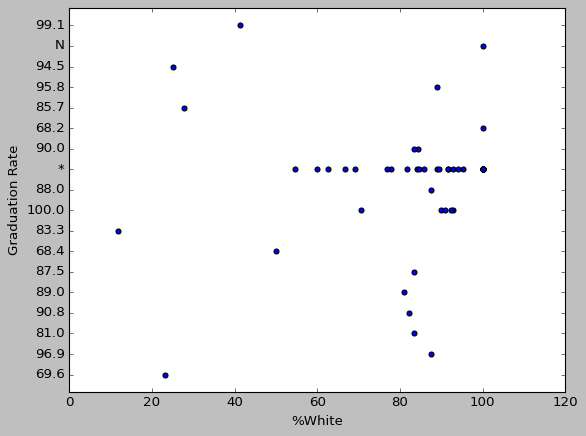

In [ ]:
#I couldn't remove the missing variables above, but here's some example scatter plots regardless.
RateIsoWhite.plot(kind='scatter', y='Graduation Rate', x='%White')

<Axes: xlabel='%Black', ylabel='Graduation Rate'>

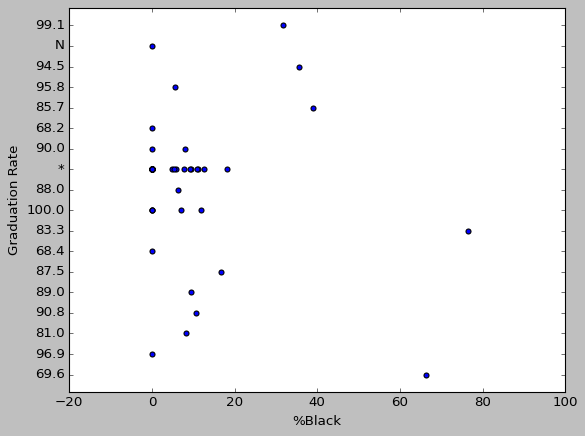

In [ ]:
RateIsoBlack.plot(kind='scatter', y='Graduation Rate', x='%Black')

In [ ]:
#Couldn't get these to work because of my inability to drop the relevant missing variable meaning pandas didn't automatically sort them by value. Will have to check in later this week, as I was unexpectedly out of town.
#Let's try showing off how much of these variables have missing data.


<Axes: xlabel='Graduation Rate'>

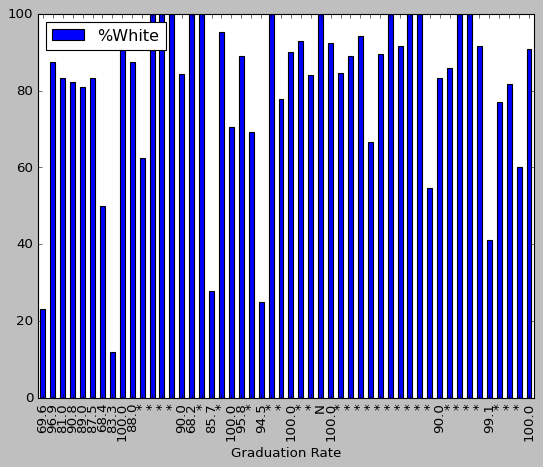

In [ ]:
RateIsoWhite.plot(kind='bar', x='Graduation Rate')

In [ ]:
#Yeah, that's about what I expected. Trying to tilt it the other way errored on non numeric variables - looks like my data was cooked from not being able to drop that. Will still try to show off what I can.

In [ ]:
#let's move onto map/recode next. I want to recode the counties into north and south jersey.
#And then, make another remapped set for those who buy into the myth of central jersey.
BlackMerged

County  District Code  \
1    Atlantic          110.0   
2    Atlantic          120.0   
5    Atlantic          590.0   
7    Atlantic         1310.0   
11   Atlantic         1790.0   
..        ...            ...   
646  Charters         7320.0   
647  Charters         7325.0   
648  Charters         7410.0   
650  Charters         7503.0   
667  Charters         8060.0   

                                              District        Position  \
1                        Atlantic City School District  Administrators   
2           Atlantic County Vocational School District  Administrators   
5                       Buena Regional School District  Administrators   
7                  Egg Harbor Township School District  Administrators   
11    Greater Egg Harbor Regional High School District  Administrators   
..                                                 ...             ...   
646                  North Star Academy Charter School  Administrators   
647                        Team Academy Charter School  Administrators   
648    Chartertech High School For The Performing Arts  Administrators   
650  Paterson Charter School For Science And Techno...  Administrators   
667             University Academy Charter High School  Administrators   

     %White  %Black  %Hispanic  %Asian  %Male  %Female  \
1      23.1    66.2        4.6     0.0   32.3     67.7   
2      87.5     0.0        0.0    12.5   75.0     25.0   
5      83.3     8.3        8.3     0.0   58.3     41.7   
7      82.1    10.7        7.1     0.0   42.9     57.1   
11     81.0     9.5        9.5     0.0   76.2     23.8   
..      ...     ...        ...     ...    ...      ...   
646    50.0    50.0        0.0     0.0   25.0     75.0   
647     0.0   100.0        0.0     0.0    0.0    100.0   
648    75.0    25.0        0.0     0.0   25.0     75.0   
650   100.0     0.0        0.0     0.0   85.7     14.3   
667    40.0    20.0       40.0     0.0   40.0     60.0   

                                         District Name School Name  \
1                        Atlantic City School District    District   
2           Atlantic County Vocational School District    District   
5                       Buena Regional School District    District   
7                  Egg Harbor Township School District    District   
11    Greater Egg Harbor Regional High School District    District   
..                                                 ...         ...   
646                  North Star Academy Charter School    District   
647                        Team Academy Charter School    District   
648    Chartertech High School For The Performing Arts    District   
650  Paterson Charter School For Science And Techno...    District   
667             University Academy Charter High School    District   

                 Student Group Graduation Rate Cohort Count Graduated _merge  
1    Black or African American            69.6          138        96   both  
2    Black or African American            96.9           65        63   both  
5    Black or African American            81.0           21        17   both  
7    Black or African American            90.8           65        59   both  
11   Black or African American            89.0          172       153   both  
..                         ...             ...          ...       ...    ...  
646  Black or African American            84.8          230       195   both  
647  Black or African American            95.1          184       175   both  
648  Black or African American            96.6           29        28   both  
650  Black or African American            97.1            *         *   both  
667  Black or African American            94.6           56        53   both  

[312 rows x 17 columns]

In [ ]:
mapping_jersey_real = {'Atlantic':'South'
                              ,'Cumberland':'South'
                              ,'Burlington':'South'
                              ,'Gloucester':'South'
                              ,'Salem':'South'
                              ,'Cape May':'South'
                              ,'Atlantic':'South'
                              ,'Camden':'South'
                              ,'Ocean' : 'South'
                              ,'Bergen':'North'
                              ,'Essex':'North'
                              ,'Hudson':'North'
                              ,'Morris':'North'
                              ,'Passaic':'North'
                              ,'Sussex':'North'
                              ,'Union':'North'
                              ,'Warren':'North'
                              ,'Mercer': 'North'
                              ,'Monmouth' : 'North'
                              ,'Middlesex':'North'
                              ,'Hunterdon':'North'
                              ,'Somerset':'North'}
BlackMergedNS = BlackMerged['County'].map(mapping_jersey_real)

In [ ]:
mapping_jersey_fake = {'Atlantic':'South'
                              ,'Cumberland':'South'
                              ,'Burlington':'South'
                              ,'Gloucester':'South'
                              ,'Salem':'South'
                              ,'Cape May':'South'
                              ,'Atlantic':'South'
                              ,'Camden':'South'
                              ,'Ocean' : 'Central'
                              ,'Bergen':'North'
                              ,'Essex':'North'
                              ,'Hudson':'North'
                              ,'Morris':'North'
                              ,'Passaic':'North'
                              ,'Sussex':'North'
                              ,'Union':'North'
                              ,'Warren':'North'
                              ,'Mercer': 'North'
                              ,'Monmouth' : 'Central'
                              ,'Middlesex':'Central'
                              ,'Hunterdon':'Central'
                              ,'Somerset':'Central'}
BlackMergedNSC = BlackMerged['County'].map(mapping_jersey_fake)

In [ ]:
BlackMergedNSC

1      South
2      South
5      South
7      South
11     South
       ...  
646      NaN
647      NaN
648      NaN
650      NaN
667      NaN
Name: County, Length: 312, dtype: object

In [ ]:
BlackMergedNS

1      South
2      South
5      South
7      South
11     South
       ...  
646      NaN
647      NaN
648      NaN
650      NaN
667      NaN
Name: County, Length: 312, dtype: object

In [ ]:
#Now I got both of them to work, but couldn't get them to stay attached to the main document on my own.
#Let's do some simple groupby and agg to make the means and standard deviations, as well as some other useful statistics.

In [ ]:
BlackMerged['Graduation Rate'].agg(['sum', 'mean'])
#Another set with problems due to the * variables. Lost more time trying to process it again.


<ipython-input-131-f1a15fc8037d>:1: FutureWarning: ['mean'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  BlackMerged['Graduation Rate'].agg(['sum', 'mean'])


sum    69.696.981.090.889.087.568.483.3100.088.0****9...
Name: Graduation Rate, dtype: object

In [ ]:
BlackMerged['%Black'].agg(['sum', 'mean'])

sum     4001.700000
mean      12.825962
Name: %Black, dtype: float64

In [ ]:
agg_func_describe = {'%Black' :['describe']}
BlackMerge.groupby(['District']).agg(agg_func_describe).round(2) #aok: need to groupby sth that is a group eg county: one county has a group (a bunch of) schools

%Black                        \
                                              describe                         
                                                 count  mean std   min   25%   
District                                                                       
Absecon Public Schools District                    1.0   0.0 NaN   0.0   0.0   
Academy Charter High School                        1.0   0.0 NaN   0.0   0.0   
Academy For Urban Leadership Charter School        1.0  50.0 NaN  50.0  50.0   
Achieve Community Charter School                   1.0  83.3 NaN  83.3  83.3   
Achievers Early College Prep Charter School        1.0  83.3 NaN  83.3  83.3   
...                                                ...   ...  ..   ...   ...   
Woodland Park School District                      1.0   0.0 NaN   0.0   0.0   
Woodland Township School District                  1.0   0.0 NaN   0.0   0.0   
Woodlynne School District                          1.0  50.0 NaN  50.0  50.0   
Woodstown-Pilesgrove Regional School District      1.0  11.1 NaN  11.1  11.1   
Wyckoff Township Public School District            1.0   0.0 NaN   0.0   0.0   

                                                                 
                                                                 
                                                50%   75%   max  
District                                                         
Absecon Public Schools District                 0.0   0.0   0.0  
Academy Charter High School                     0.0   0.0   0.0  
Academy For Urban Leadership Charter School    50.0  50.0  50.0  
Achieve Community Charter School               83.3  83.3  83.3  
Achievers Early College Prep Charter School    83.3  83.3  83.3  
...                                             ...   ...   ...  
Woodland Park School District                   0.0   0.0   0.0  
Woodland Township School District               0.0   0.0   0.0  
Woodlynne School District                      50.0  50.0  50.0  
Woodstown-Pilesgrove Regional School District  11.1  11.1  11.1  
Wyckoff Township Public School District         0.0   0.0   0.0  

[664 rows x 8 columns]

In [ ]:
#After consigning myself to turning in something bad and working through office hours, I realized that I had forgotten enitirely about using Replace on condition. Maybe I can use that
#to set the * to 0 and then try to drop it with the initial command?
BlackMerged['Graduation Rate'] = np.where(BlackMerged['Graduation Rate'] == "*", 0)

ValueError: ignored

In [ ]:
#Nope - lost on this. Unfortunate. Turning in what I at least tried to get done.